In [9]:
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports:
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# Visualization imports:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter
import seaborn

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [10]:
binsize = 10_000

## Load data

In [26]:
# Open cool file with Micro-C data:
clr_orig = cooler.Cooler(f"/Users/amulyagarimella/Documents/2241finalproject/data/GM12878.GSE115524/GM12878.GSE115524.Homo_Sapiens.CTCF.b1.mcool::resolutions/{binsize}")

clr_orig_5kb = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/data/GM12878.GSE115524/GM12878.GSE115524.Homo_Sapiens.CTCF.b1.mcool::resolutions/5000")

clr_roi = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/roi/2025-05-06_08-06-32/21_predicted_hic.cool::/")
clr_full = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/full/2025-05-05_20-05-06/21_predicted_hic.cool::/")

In [31]:

# define genomic view that will be used to call dots and pre-compute expected

# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)


In [32]:
# Select only chromosomes that are present in the cooler.
hg38_arms = hg38_arms.set_index("chrom").loc['chr21'].reset_index()

In [34]:
hg38_arms

,chrom,start,end,name
0,chr21,0,12000000,chr21_p
1,chr21,12000000,46709983,chr21_q


## Original cooler

In [35]:

# intra-arm expected
expected = cooltools.expected_cis(
    clr_orig,
    view_df=hg38_arms,
    nproc=4,
)

INFO:root:creating a Pool of 4 workers
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


In [89]:
dots_df = cooltools.dots(
    clr_orig,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root:creating a Pool of 4 workers
INFO:root:convolving 24 tiles to build histograms for lambda-bins
INFO:root:Done building histograms in 0.847 sec ...
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/cooltools/api/dotfinder.py:977: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmin()  # index of the first positive difference
/Users/amulyagarimella/Documents/2241finalproject/metrics_env/lib/python3.11/site-packages/co

### visualize

In [106]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none", binsize=10000):
    """
    yield a series of rectangles around called dots in a given region
    """
    chr, start, end = region
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = (e1 - s1) // binsize
        width2 = (e2 - s2) // binsize
        start1 = (s1 - start) // binsize 
        start2 = (s2 - start) // binsize
        #print(s1, s2, e1, e2)
        print(width1, width2, start1, start2)
        if loc == "upper":
            yield patches.Rectangle((start2, start1 ), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((start1, start2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

In [107]:
dots_df

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,region,cstart1,cstart2,c_label,c_size,region1,region2
0,chr21,13970000,13980000,chr21,14120000,14130000,16,5.082542,7.015940,5.544209,...,6.633367e-02,1.605931e-02,1.829092e-02,chr21_q,1.397000e+07,1.411500e+07,0,2,chr21_q,chr21_q
1,chr21,14390000,14400000,chr21,14730000,14740000,29,11.663882,14.899812,12.692890,...,8.885357e-03,5.485164e-04,4.432672e-04,chr21_q,1.441000e+07,1.473000e+07,1,1,chr21_q,chr21_q
2,chr21,14450000,14460000,chr21,14730000,14740000,61,21.968756,23.991843,24.626015,...,6.762026e-09,8.105168e-09,1.467526e-12,chr21_q,1.444500e+07,1.473000e+07,6,3,chr21_q,chr21_q
3,chr21,14530000,14540000,chr21,14730000,14740000,57,26.663210,29.203503,26.732469,...,9.728731e-05,1.060867e-04,1.067788e-04,chr21_q,1.453500e+07,1.472750e+07,8,4,chr21_q,chr21_q
4,chr21,14870000,14880000,chr21,15060000,15070000,21,4.862145,5.294745,6.330144,...,2.044743e-04,1.993049e-04,7.711684e-06,chr21_q,1.486667e+07,1.505667e+07,12,3,chr21_q,chr21_q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,chr21,45550000,45560000,chr21,45820000,45830000,97,24.666518,37.193740,30.021509,...,1.119979e-13,1.874091e-19,4.273688e-19,chr21_q,4.555500e+07,4.581667e+07,268,6,chr21_q,chr21_q
160,chr21,45970000,45980000,chr21,46330000,46340000,16,2.672762,2.728835,5.588864,...,5.990149e-05,1.605931e-02,3.112454e-05,chr21_q,4.597000e+07,4.632500e+07,271,2,chr21_q,chr21_q
161,chr21,46140000,46150000,chr21,46370000,46380000,40,18.269607,12.260962,23.985842,...,1.115017e-08,1.366238e-02,2.339599e-04,chr21_q,4.614000e+07,4.635500e+07,273,2,chr21_q,chr21_q
162,chr21,46280000,46290000,chr21,46630000,46640000,28,12.042693,14.660586,9.122533,...,1.522620e-02,5.598225e-05,9.258661e-04,chr21_q,4.628000e+07,4.663000e+07,275,1,chr21_q,chr21_q


In [108]:
# define a region to look into as an example
chrom = "chr21"
start_bp = dots_df['start1'].iloc[0]
size_bp = np.max([(dots_df['start2'].iloc[0] - dots_df['start1'].iloc[0]), 1_000_000])

binsize = 10000

region = ('chr21', start_bp, (start_bp + size_bp))

# heatmap kwargs
matshow_kwargs = dict(
    cmap='YlOrBr',
    norm=LogNorm(vmax=0.05),
    extent=(start, end, end, start)
)

# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

1 1 0 15
Rectangle(xy=(15, 0), width=1, height=1, angle=0)
1 1 42 76
Rectangle(xy=(76, 42), width=1, height=1, angle=0)
1 1 48 76
Rectangle(xy=(76, 48), width=1, height=1, angle=0)
1 1 56 76
Rectangle(xy=(76, 56), width=1, height=1, angle=0)


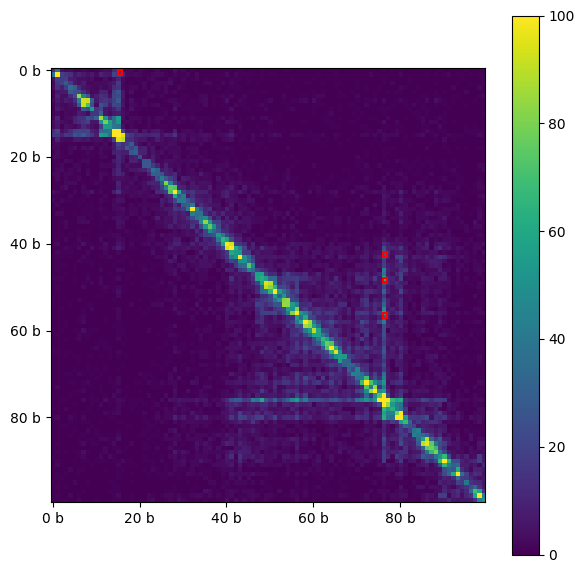

In [110]:
# compute heatmap for the region
region_matrix = clr_orig.matrix(balance=False).fetch(region)
#for diag in [-1,0,1]:
#    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow(region_matrix,vmax=100)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region, lw=1.5, ec="red"):
    print(box)
    ax.add_patch(box)

plt.show()

## Fully enhanced

## Enhanced at ROIs